In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import glob
import os

import dask

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [2]:
# Directories
nldas_path = "/storage/group/pches/default/public/NLDAS"
smap_path = "/storage/group/pches/default/public/SMAP"
log_path = "/storage/home/dcl5300/work/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs"
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [3]:
# Read params
df_params = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params_extra.csv')

## Dask cluster

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    account="pches",
    # account="open",
    cores=1,
    memory="4GB",
    walltime="00:20:00",
)

cluster.scale(jobs=20)

In [3]:
# print(cluster.job_script())

In [4]:
from dask.distributed import Client

client = Client(cluster)

client

<Client: 'tcp://10.6.0.174:37395' processes=0 threads=0, memory=0 B>

# Evaluation plots

In [4]:
# Read sim
def read_sim(obs, iparam):
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/out/{str(iparam)}.npy')
    # sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS_old/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
                lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Return
    return ds_sim

In [5]:
# Plotting function
def plot_ts(obs, lat, lon, metric, n_cutoff, tmin, ylabel, xlabel, ytext, ax):
    """
    Plots timeseries of top `n_cutoff` results for a given lat, lon, including all 
    observational products.
    """
    # Read obs and subset
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/{obs.upper()}_validation.nc')
    # ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS_old/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs.sel(lat=lat, lon=lon, method='nearest')['soilMoist'][tmin:]
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
    # df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_old/soilMoist_rmse_skip{str(tmin)}_gpa.csv')
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(obs, iparam_best).sel(lat=lat, lon=lon, method='nearest')['soilMoist'][tmin:]
    
    # For surprise index
    sim_all = []
    
    # Plot simulations
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(obs, iparam).sel(lat=lat, lon=lon, method='nearest')['soilMoist'][tmin:]
        # Plot
        ds_tmp.plot(ax=ax, color='silver', alpha=0.8)
        # Append for surpise index
        sim_all.append(ds_tmp.to_numpy())
    
    # Plot obs
    obs_tmp.plot(ax=ax, color='darkred', zorder=3)

    # Plot best
    ds_best.plot(ax=ax, color='dimgrey', zorder=2)
    best_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean())

    # Get correlation
    best_corr = np.corrcoef(ds_best, obs_tmp)[0,1]
    
    # Get surprise index
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    
    coverage = 1 - ((((obs_tmp.to_numpy() > maxs).sum() + (obs_tmp.to_numpy() < mins).sum())) / len(obs_tmp))
    
    # Print info
    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.05, y=ytext,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

    ax.grid()
    # ax.legend()
    ax.set_title('')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

In [6]:
# Plotting function
def plot_map(obs, metric, plot_type, n_cutoff, tmin, cbar, title, ax):
    """
    Plots the RMSE map and top `n_cutoff` coverage for a given obs-product.
    """
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/{obs.upper()}_validation.nc')
    # ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS_old/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs['soilMoist'][tmin:]
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
    # df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS_old/soilMoist_rmse_skip{str(tmin)}_gpa.csv')
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(obs, iparam_best)['soilMoist'][tmin:]

    if plot_type == 'coverage':
        # For coverage
        maxs = np.zeros(ds_best.shape)
        mins = np.ones(ds_best.shape) * 1e6
    
        # Get ensemble bounds
        for iparam in iparam_top_n:
            # Read
            ds_tmp = read_sim(obs, iparam)['soilMoist'][tmin:]
            # Iterativalely calculate bounds
            maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
            mins = np.min([mins, ds_tmp.to_numpy()], axis=0)
    
        # Get coverage
        coverage = 100 * (1 - ((((obs_tmp.to_numpy() > maxs).sum(axis=0) + (obs_tmp.to_numpy() < mins).sum(axis=0))) / obs_tmp.shape[0]))

        # Construct ds for coverage
        ds_coverage = xr.Dataset(
            data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125),
                lat=np.arange(36.063, 49.313001, 0.125)))

        # Plot coverage
        p = ds_coverage.coverage.plot(ax=ax, vmin=0, vmax=100, cmap = "Greens", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Coverage (%)",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'rmse':
        # Plot best RMSE
        ds_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean(dim='time'))
        p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best RMSE [mm]",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'corr':
        # Plot best correlation
        ds_corr = xr.corr(ds_best, obs_tmp, dim='time')
        p = ds_corr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, levels=21, cmap = "RdBu", transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best correlation",
                     ax=ax,
                     pad=0.04)

    # Tidy
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

## Main plot

In [7]:
# Set params
n_cutoff = 150
tmin = 0
metric = 'rmse_gpa'

lat1, lon1 = 40.2,-89.1
lat2, lon2 = 41.93255367319802, -95.74224906197333

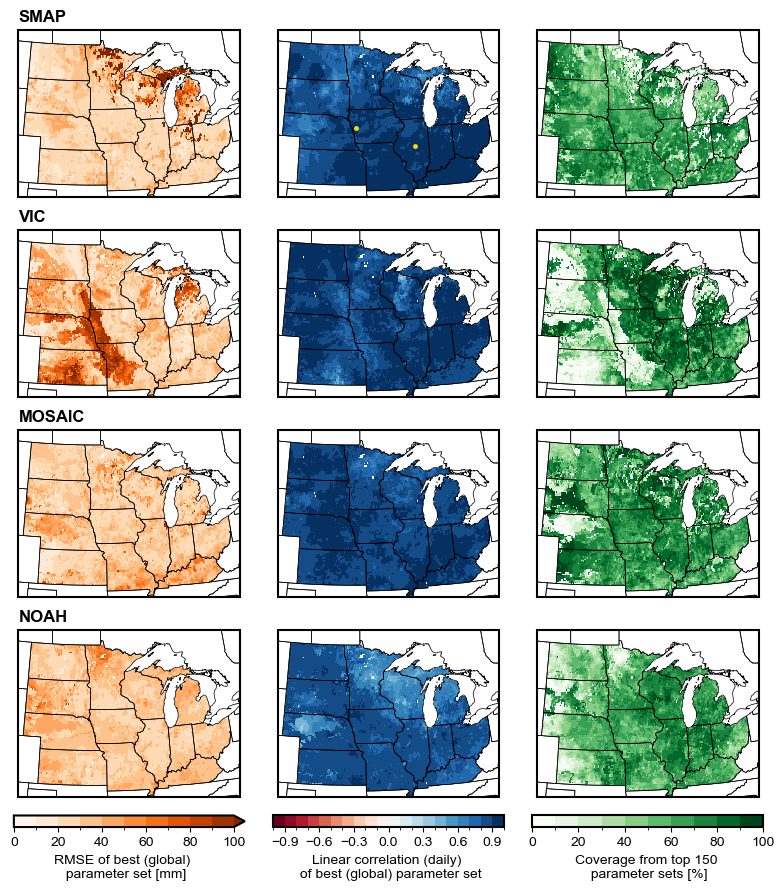

In [152]:
# Main plot: maps
fig, axs = plt.subplots(4, 3, figsize=(10, 12), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.01, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

# RMSE
plot_type = 'rmse'
p = plot_map(obs='smap', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[0, 0])
p = plot_map(obs='vic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[1, 0])
p = plot_map(obs='mosaic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[2, 0])
p = plot_map(obs='noah', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[3, 0])

fig.colorbar(p,
             orientation="horizontal",
             label="RMSE of best (global) \n parameter set [mm]",
             ax=axs[:,0],
             shrink=0.9,
             pad=0.02)

# Corr
plot_type = 'corr'
p = plot_map(obs='smap', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[0, 1])
p = plot_map(obs='vic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[1, 1])
p = plot_map(obs='mosaic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[2, 1])
p = plot_map(obs='noah', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[3, 1])
fig.colorbar(p,
             orientation="horizontal",
             label="Linear correlation (daily) \n of best (global) parameter set",
             ax=axs[:,1],
             shrink=0.9,
             pad=0.02)

# Mark ts spots
# Add city locations to top left plot
axs[0, 1].scatter(
    x=lon1,
    y=lat1,
    s=25,
    marker=".",
    c="gold",
    transform=ccrs.PlateCarree(),
    zorder=500,
)
axs[0, 1].scatter(
    x=lon2,
    y=lat2,
    s=25,
    marker=".",
    c="gold",
    transform=ccrs.PlateCarree(),
    zorder=500,
)

# Coverage
plot_type = 'coverage'
p = plot_map(obs='smap', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[0, 2])
p = plot_map(obs='vic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[1, 2])
p = plot_map(obs='mosaic', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[2, 2])
p = plot_map(obs='noah', metric=metric, plot_type=plot_type, n_cutoff=n_cutoff, tmin=tmin, cbar=False, title = '', ax=axs[3, 2])

fig.colorbar(p,
             orientation="horizontal",
             label=f"Coverage from top {str(n_cutoff)} \n parameter sets [%]",
             ax=axs[:,2],
             shrink=0.9,
             pad=0.02)

for ido, obs in enumerate(['SMAP', 'VIC', 'MOSAIC', 'NOAH']):
    axs[ido,0].set_title(obs, loc='left', fontdict={'fontweight': 'bold'})

# plt.tight_layout()
# plt.show()
plt.savefig('../figs/maps_all.png', dpi=600, bbox_inches='tight')

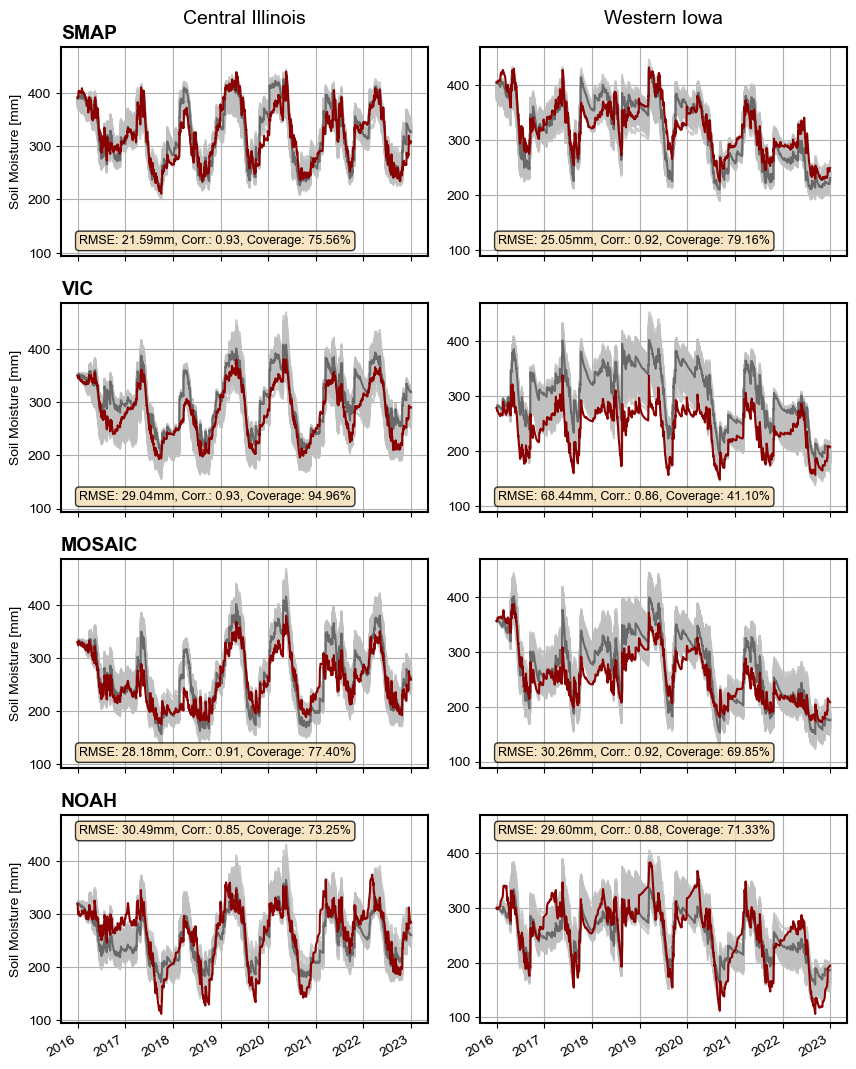

In [8]:
# Main plot: timeseries
fig = plt.figure(figsize=(8, 11))
subfigs = fig.subfigures(1, 2, wspace=0.1, hspace=0.05)

ytext=0.1

# Central IL
axs = subfigs[0].subplots(4, 1, sharey=True, sharex=True)
subfigs[0].suptitle('Central Illinois', fontsize=14, y=1.0)

plot_ts(obs="smap", lat=lat1, lon=lon1, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ytext=ytext, ax=axs[0])
plot_ts(obs="vic", lat=lat1, lon=lon1, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ytext=ytext, ax=axs[1])
plot_ts(obs="mosaic", lat=lat1, lon=lon1, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ytext=ytext, ax=axs[2])
plot_ts(obs="noah", lat=lat1, lon=lon1, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ytext=0.95, ax=axs[3])

# Add obs
for ido, obs in enumerate(['SMAP', 'VIC', 'MOSAIC', 'NOAH']):
    axs[ido].set_title(obs, loc='left', fontdict={'fontweight': 'bold', 'fontsize':14})

# Western NE
axs = subfigs[1].subplots(4, 1, sharey=True, sharex=True)
subfigs[1].suptitle('Western Iowa', fontsize=14, y=1.0)

plot_ts(obs="smap", lat=lat2, lon=lon2, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=ytext, ax=axs[0])
plot_ts(obs="vic", lat=lat2, lon=lon2, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=ytext, ax=axs[1])
plot_ts(obs="mosaic", lat=lat2, lon=lon2, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=ytext, ax=axs[2])
plot_ts(obs="noah", lat=lat2, lon=lon2, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=0.95, ax=axs[3])

plt.tight_layout()
# plt.savefig('../figs/timeseries.pdf', bbox_inches='tight')
plt.savefig('../figs/timeseries.png', dpi=600, bbox_inches='tight')

## Parameters

### Distributions

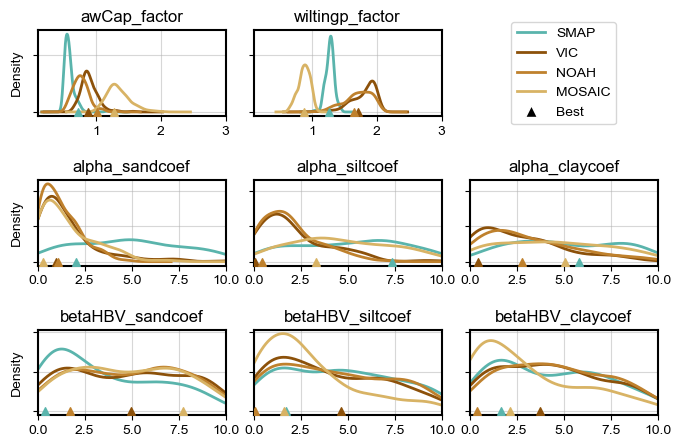

In [7]:
# Do the parameters match?
n_cutoff = 150
metric = 'rmse_gpa'
tmin = 0

# params = ['fieldCap_sandcoef', 'fieldCap_siltcoef', 'fieldCap_claycoef',
#           'wiltingp_sandcoef', 'wiltingp_siltcoef', 'wiltingp_claycoef',
#           'alpha_sandcoef', 'alpha_siltcoef', 'alpha_claycoef',
#           'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
# priors = ['U(0, 0.75)', 'U(0, 0.75)', 'U(0, 0.75)',
#           'U(0, 1)', 'U(0, 1)', 'U(0, 1)',
#           'U(0, 10)', 'U(0, 10)', 'U(0, 10)',
#           'U(0, 10)', 'U(0, 10)', 'U(0, 10)']
# xlims = [[0, 0.75], [0, 0.75], [0, 0.75],
#           [0, 1], [0, 1], [0, 1],
#           [0, 10], [0, 10], [0, 10],
#           [0, 10], [0, 10], [0, 10]]

params = ['awCap_factor',
          'wiltingp_factor',
          'alpha_sandcoef', 'alpha_siltcoef', 'alpha_claycoef',
          'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
priors = ['U(0.1, 5)',
          'U(0.1, 5)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)']
xlims = [[0.1, 3],
          [0.1, 3],
          [0, 10], [0, 10], [0, 10],
          [0, 10], [0, 10], [0, 10]]
# obs_all = ['noah', 'mosaic']
# obs_colors = ['C0', 'C0', 'C0', 'C0']

obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['#5ab4ac', '#8c510a', '#bf812d', '#d8b365']

fig, axs = plt.subplots(3,3, figsize=(8,5), sharey='row', gridspec_kw={'hspace':0.75, 'wspace':0.15})
axs=axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
        
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        if idx >= 2:
            idxx = idx + 1
        else:
            idxx = idx
        # Plot
        df_params.iloc[iparam_top_n][param].plot.kde(ax=axs[idxx], color=obs_colors[ido], label=obs_all[ido], lw=2)
        # Best
        axs[idxx].scatter(x = [df_params.iloc[iparam_best][param]],
                         y = [0],
                         marker = '^', color=obs_colors[ido], zorder=100, s=30)


for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    axs[idxx].set_title(f'{param}')
    axs[idxx].set_xlim(xlims[idx])
    axs[idxx].set_yticklabels([])
    axs[idxx].grid(alpha=0.5)

# Legend in odd plot
axs[2].axis("off")
axs[2].set_xlim(axs[2].get_xlim())
axs[2].set_ylim(axs[2].get_ylim())
legend_elements = [Line2D([10], [10], color=obs_colors[0], lw=2, label=obs_all[0].upper()),
                    Line2D([10], [10], color=obs_colors[1], lw=2, label=obs_all[1].upper()),
                    Line2D([10], [10], color=obs_colors[2], lw=2, label=obs_all[2].upper()),
                    Line2D([10], [10], color=obs_colors[3], lw=2, label=obs_all[3].upper()),
                    Line2D([10], [10], marker='^', markerfacecolor='black', color='w', markersize=9, label='Best')]

axs[2].legend(handles=legend_elements, loc='center')

plt.savefig('../figs/posterior.pdf', bbox_inches='tight')

### Maps

In [18]:
# Subset to central US
def _subset_centralUS(ds):
    # Define central US
    centralUS_states = ["Illinois", "Iowa", "Wisconsin", "Minnesota", "North Dakota", "South Dakota", "Nebraska", "Kansas", "Missouri", "Indiana", "Ohio", "Michigan", "Kentucky"]
    # Subset
    centralUS_index = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.map_keys(centralUS_states)
    centralUS_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.mask(ds)
    ds_centralUS = ds.where(centralUS_mask.isin(centralUS_index), drop=True)
    # Return
    return ds_centralUS

In [19]:
# Read fractions
ds_clayfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/clayfrac_NLDASgrid.nc'))
ds_sandfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/sandfrac_NLDASgrid.nc'))
ds_siltfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/siltfrac_NLDASgrid.nc'))

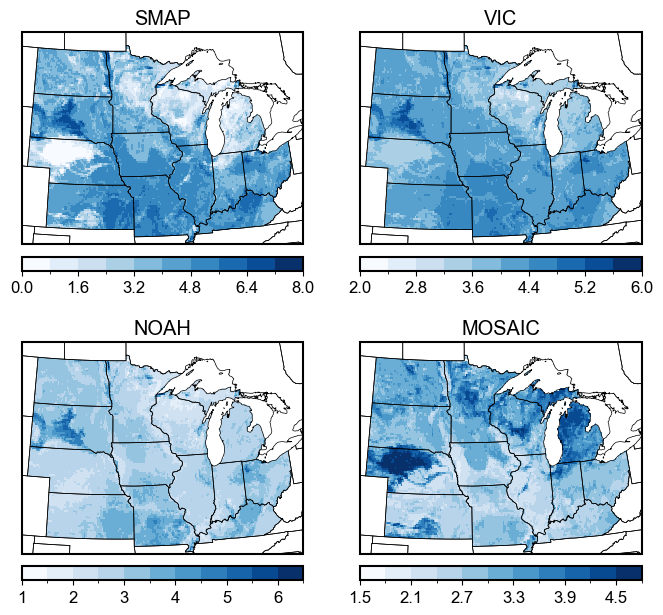

In [21]:
# Plot betaHBV
fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.2, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best betaHBV map
    betaHBV_sandcoef = df_params.iloc[iparam_best]['betaHBV_sandcoef']
    betaHBV_siltcoef = df_params.iloc[iparam_best]['betaHBV_siltcoef']
    betaHBV_claycoef = df_params.iloc[iparam_best]['betaHBV_claycoef']

    betaHBV = (1. + (betaHBV_sandcoef * ds_sandfrac['sandfrac']) + \
    (betaHBV_siltcoef * ds_siltfrac['siltfrac']) + \
    (betaHBV_claycoef * ds_clayfrac['clayfrac'])) / 100.
    # Plot
    p = betaHBV.plot(ax=axs[ido],
                     cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

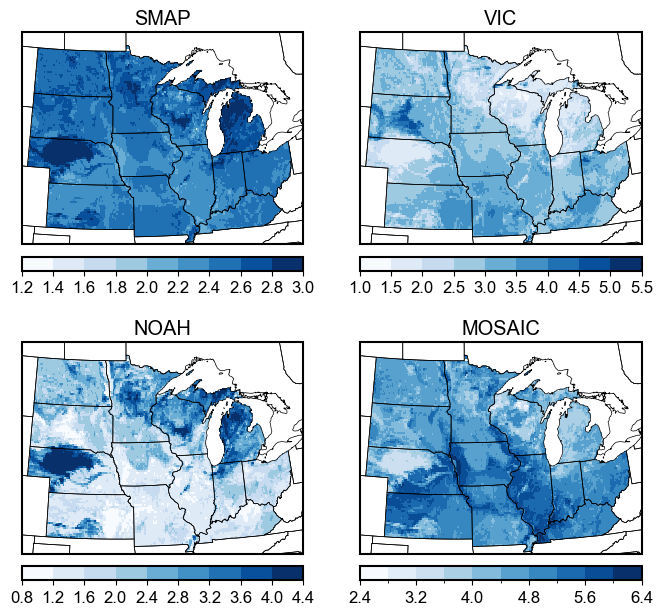

In [80]:
# Plot alpha
fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.2, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best alpha map
    alpha_sandcoef = df_params.iloc[iparam_best]['alpha_sandcoef']
    alpha_siltcoef = df_params.iloc[iparam_best]['alpha_siltcoef']
    alpha_claycoef = df_params.iloc[iparam_best]['alpha_claycoef']

    alpha = (1. + (alpha_sandcoef * ds_sandfrac['sandfrac']) + \
    (alpha_siltcoef * ds_siltfrac['siltfrac']) + \
    (alpha_claycoef * ds_clayfrac['clayfrac'])) / 100.
    # Plot
    p = alpha.plot(ax=axs[ido],
                     cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

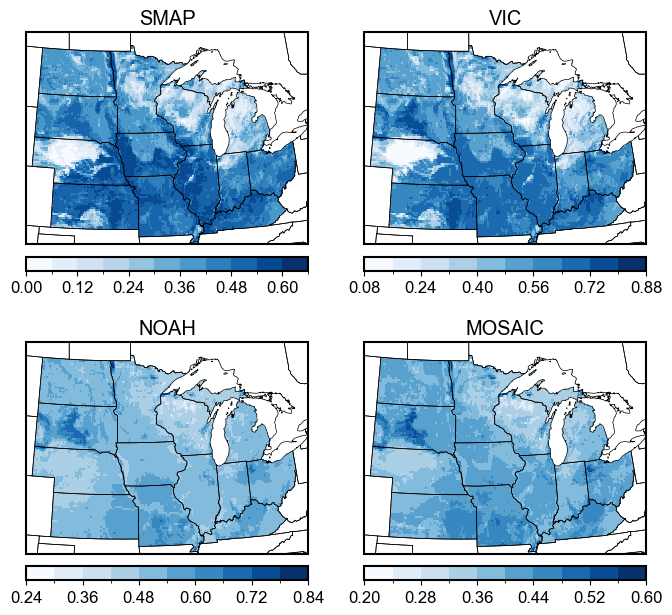

In [78]:
# Plot wiltingp
fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.2, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best wiltingp map
    wiltingp_sandcoef = df_params.iloc[iparam_best]['wiltingp_sandcoef']
    wiltingp_siltcoef = df_params.iloc[iparam_best]['wiltingp_siltcoef']
    wiltingp_claycoef = df_params.iloc[iparam_best]['wiltingp_claycoef']

    wiltingp = (1. + (wiltingp_sandcoef * ds_sandfrac['sandfrac']) + \
    (wiltingp_siltcoef * ds_siltfrac['siltfrac']) + \
    (wiltingp_claycoef * ds_clayfrac['clayfrac'])) / 100.
    # Plot
    p = wiltingp.plot(ax=axs[ido],
                     cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

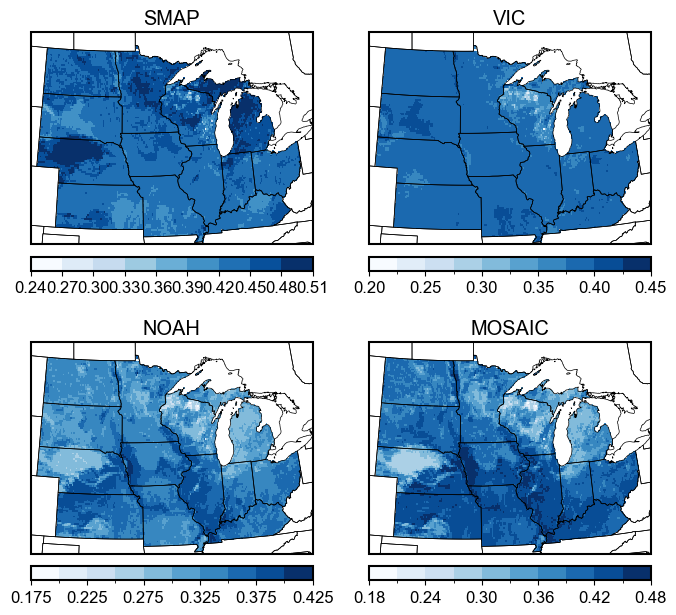

In [77]:
# Plot fieldCap
fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.2, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best fieldCap map
    fieldCap_sandcoef = df_params.iloc[iparam_best]['fieldCap_sandcoef']
    fieldCap_siltcoef = df_params.iloc[iparam_best]['fieldCap_siltcoef']
    fieldCap_claycoef = df_params.iloc[iparam_best]['fieldCap_claycoef']

    fieldCap = (1. + (fieldCap_sandcoef * ds_sandfrac['sandfrac']) + \
    (fieldCap_siltcoef * ds_siltfrac['siltfrac']) + \
    (fieldCap_claycoef * ds_clayfrac['clayfrac'])) / 100.
    # Plot
    p = fieldCap.plot(ax=axs[ido],
                      cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Timeseries

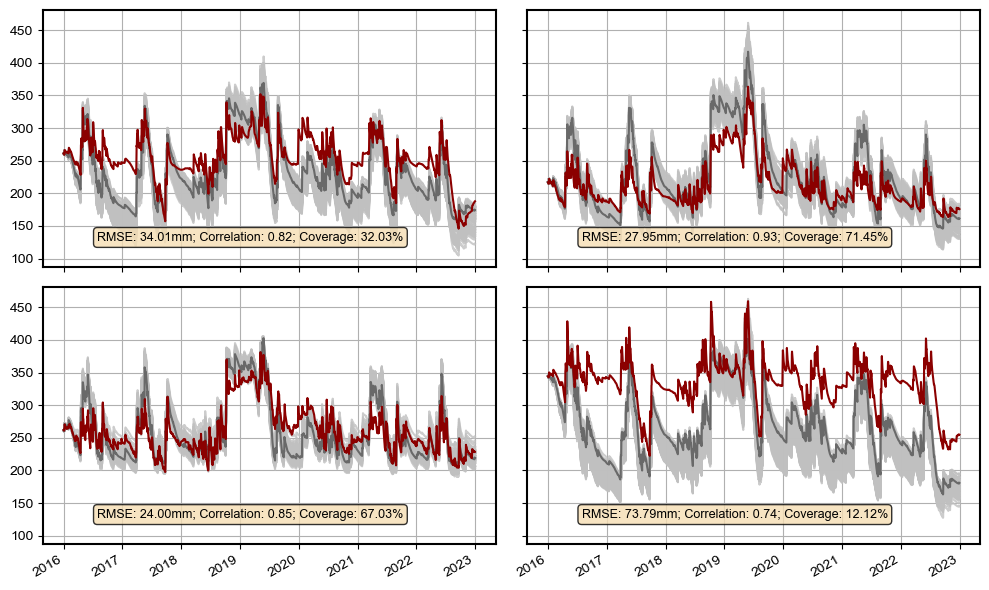

In [8]:
# Main plot
lat, lon = 38.71914551348558, -98.43861498069873
n_cutoff = 100
tmin = 0
metric = 'rmse_gpa'

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="noah", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=0.14, ax=axs[0,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=0.14, ax=axs[0,1])
plot_ts(obs="smap", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=0.14, ax=axs[1,0])
plot_ts(obs="vic", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ytext=0.14, ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

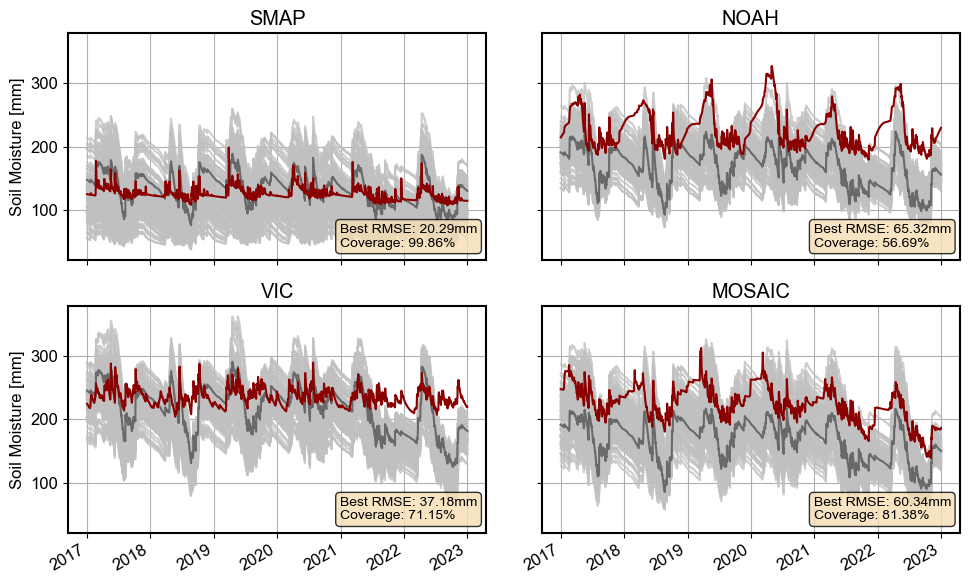

In [24]:
# Main plot
lat, lon = 46,-90
n_cutoff = 100
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

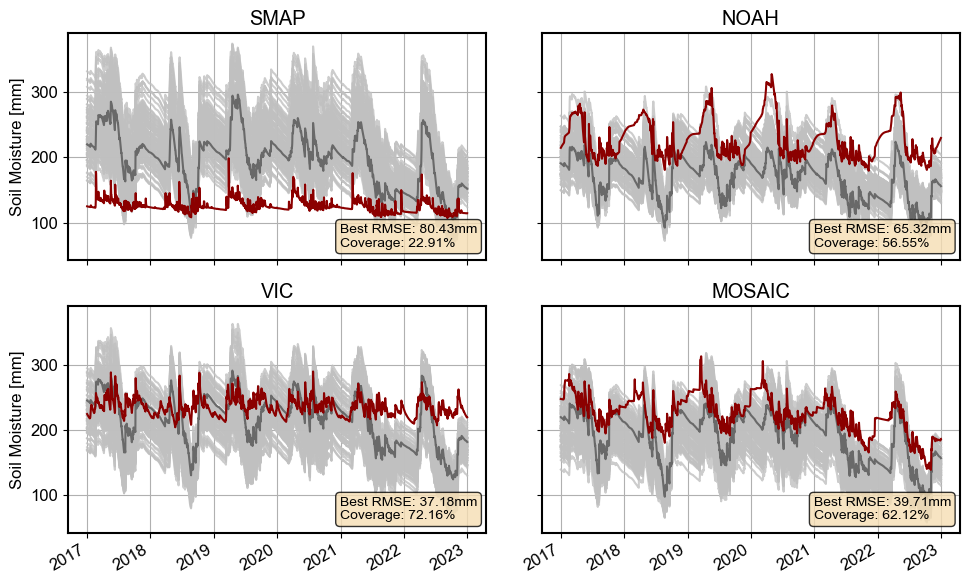

In [54]:
# Main plot
lat, lon = 46,-90
n_cutoff = 100
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

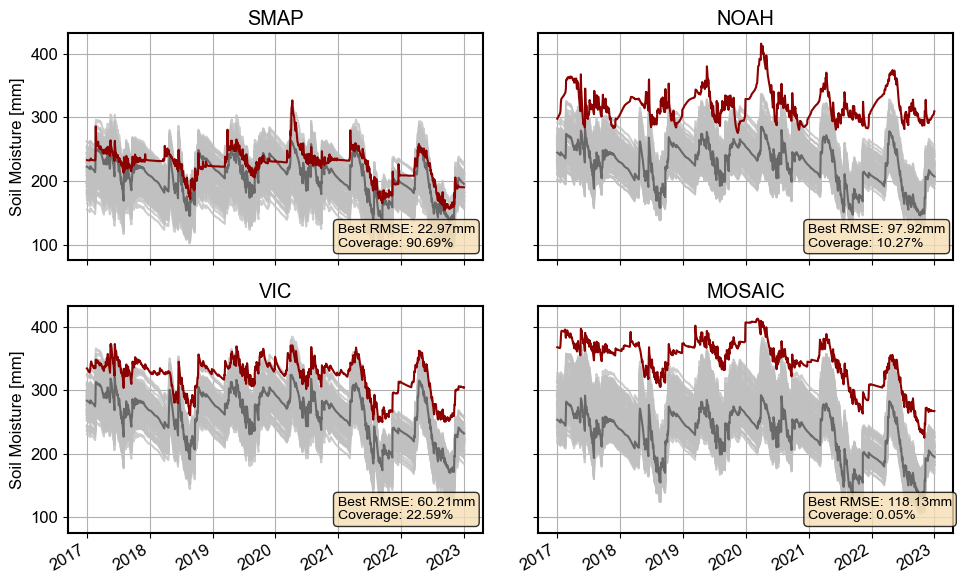

In [25]:
# Main plot
lat, lon = 46,-90.8
n_cutoff = 100
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

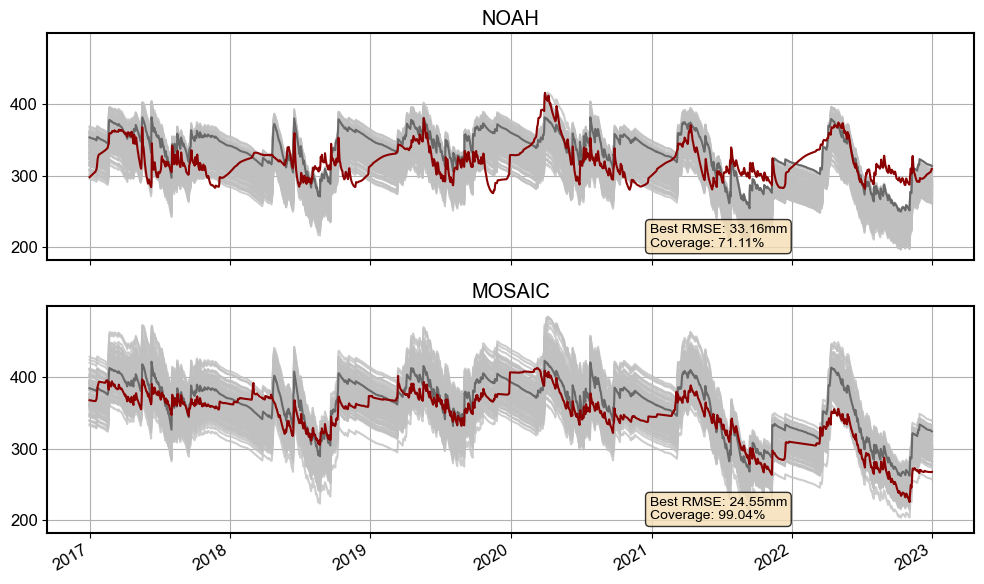

In [26]:
# Main plot
lat, lon = 46,-90.8
n_cutoff = 100
tmin = 366
metric = 'rmse_gpa'

fig, axs = plt.subplots(2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="noah", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0])
plot_ts(obs="mosaic", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

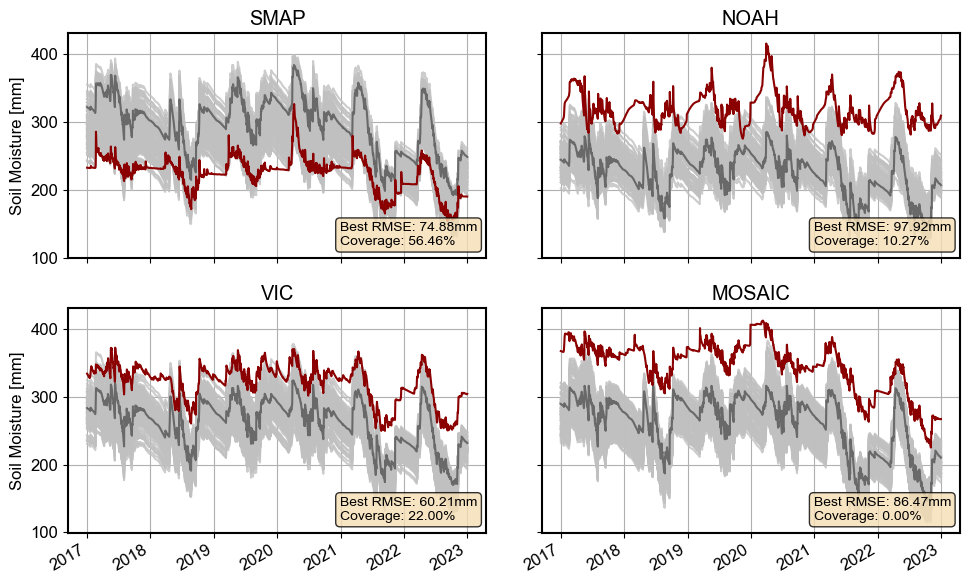

In [55]:
# Main plot
lat, lon = 46,-90.8
n_cutoff = 100
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

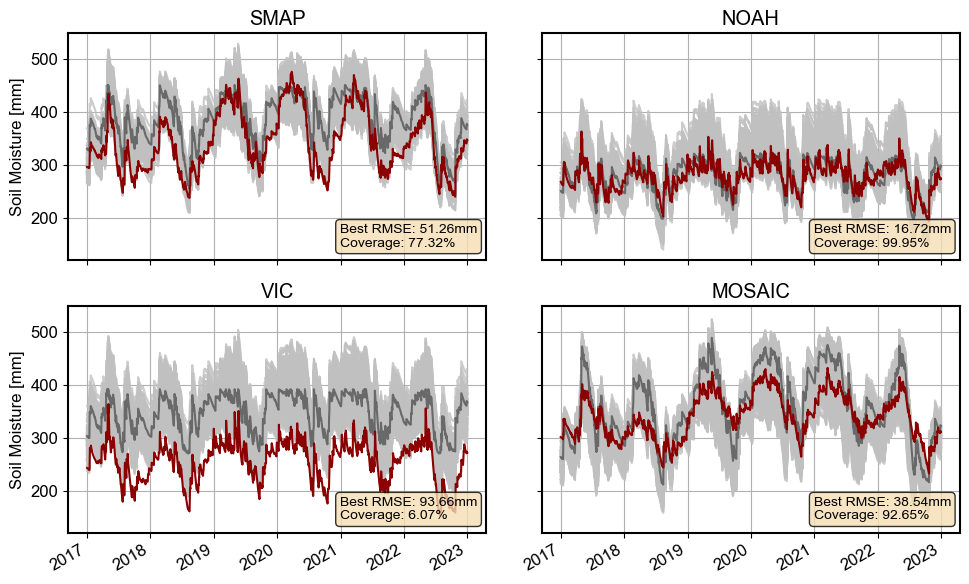

In [33]:
# Main plot
lat, lon = 37.8,-93.5
n_cutoff = 150
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

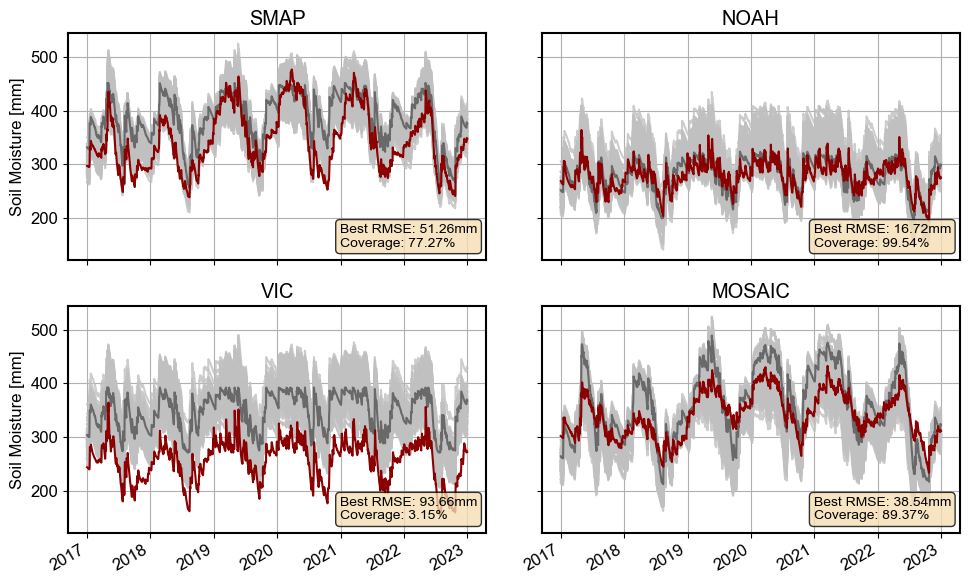

In [29]:
# Main plot
lat, lon = 37.8,-93.5
n_cutoff = 100
tmin = 366

fig, axs = plt.subplots(2,2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="smap", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[0,0])
plot_ts(obs="noah", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0,1])
plot_ts(obs="vic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="Soil Moisture [mm]", xlabel="", ax=axs[1,0])
plot_ts(obs="mosaic", lat=lat, lon=lon, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1,1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

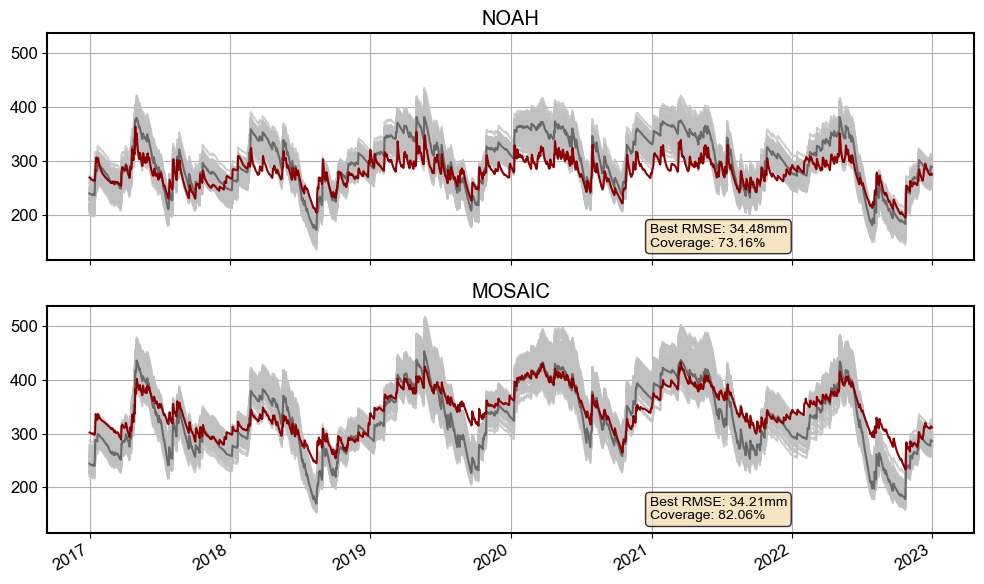

In [31]:
# Main plot
lat, lon = 37.8,-93.5
n_cutoff = 100
tmin = 366
metric = 'rmse_gpa'

fig, axs = plt.subplots(2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="noah", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0])
plot_ts(obs="mosaic", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

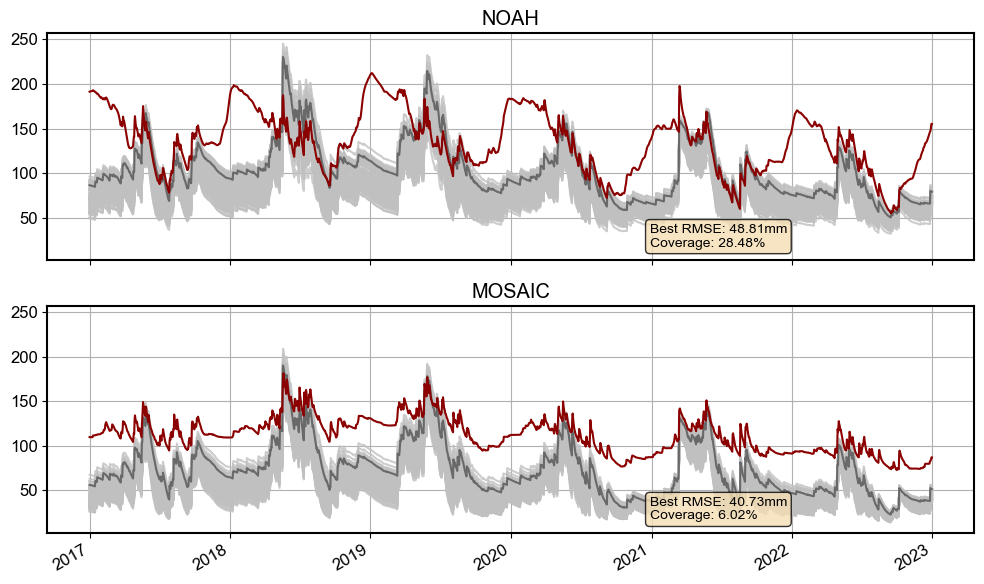

In [40]:
# Main plot
lat, lon = 42.06,-101.7
n_cutoff = 100
tmin = 366
metric = 'rmse_gpa'

fig, axs = plt.subplots(2, figsize=(10,6), sharey=True, sharex=True)

plot_ts(obs="noah", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[0])
plot_ts(obs="mosaic", lat=lat, lon=lon, metric=metric, n_cutoff=n_cutoff, tmin=tmin, ylabel="", xlabel="", ax=axs[1])

plt.tight_layout()
# plt.savefig('../figs/lat40nlon90w_ts_top100.pdf')
plt.show()

## Spatial plot

In [6]:
# Plotting function
def plot_map(obs, metric, n_cutoff, tmin, axs):
    """
    Plots the RMSE map and top `n_cutoff` coverage for a given obs-product.
    """
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs['soilMoist'][tmin:]
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    ds_best = read_sim(obs, iparam_best)['soilMoist'][tmin:]
    
    # For coverage
    maxs = np.zeros(ds_best.shape)
    mins = np.ones(ds_best.shape) * 1e6
    
    # Get ensemble bounds
    for iparam in iparam_top_n:
        # Read
        ds_tmp = read_sim(obs, iparam)['soilMoist'][tmin:]
        # Iterativalely calculate bounds
        maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
        mins = np.min([mins, ds_tmp.to_numpy()], axis=0)
    
    # Get coverage
    coverage = 100 * (1 - ((((obs_tmp.to_numpy() > maxs).sum(axis=0) + (obs_tmp.to_numpy() < mins).sum(axis=0))) / obs_tmp.shape[0]))

    # Construct ds for coverage
    ds_coverage = xr.Dataset(
        data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
        coords=dict(
            lon=np.arange(-103.938, -80.5629999, 0.125),
            lat=np.arange(36.063, 49.313001, 0.125)))

    # Plot coverage
    p = ds_coverage.coverage.plot(ax=axs[1], vmin=0, vmax=100, cmap = "Greens", add_colorbar=False, levels=6, transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Coverage (%)",
                 ax=axs[1],
                 pad=0.04)

    # Plot best RMSE
    ds_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean(dim='time'))
    p = ds_rmse.plot(ax=axs[0], vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Best RMSE [mm]",
                 ax=axs[0],
                 pad=0.04)

    # Tidy
    for ax in axs:
        ax.coastlines()
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

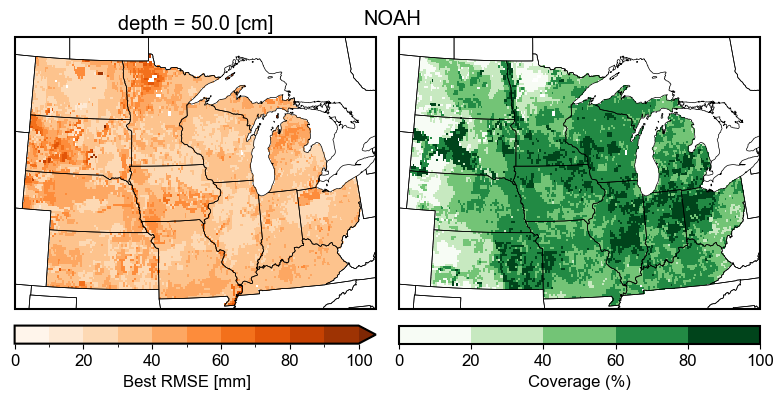

In [8]:
# NOAH
obs = 'noah'
n_cutoff = 100
tmin = 366
metric = 'rmse_gpa'

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, metric=metric, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

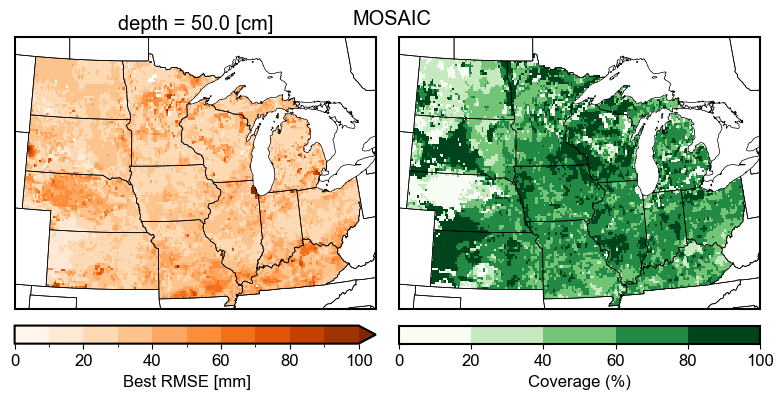

In [9]:
# MOSAIC
obs = 'mosaic'
n_cutoff = 100
tmin = 366
metric = 'rmse_gpa'

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, metric=metric, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

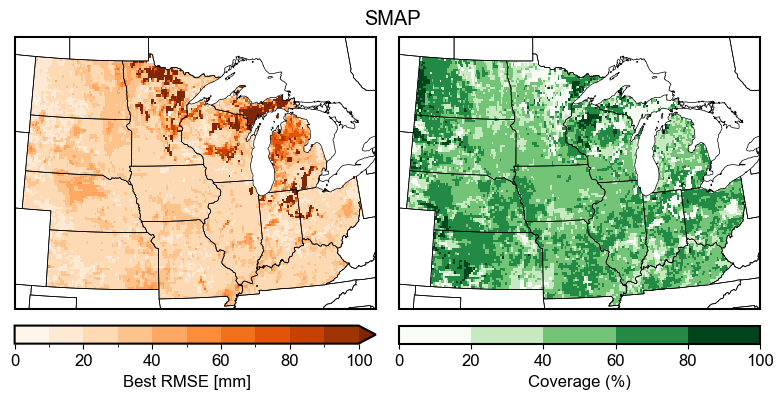

In [10]:
# SMAP
obs = 'smap'
n_cutoff = 100
tmin = 0
metric = 'rmse_gpa'

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, metric=metric, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

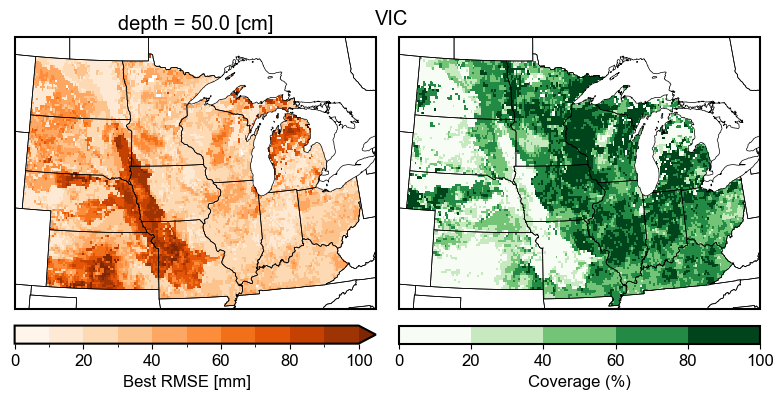

In [11]:
# VIC
obs = 'vic'
n_cutoff = 100
tmin = 0
metric = 'rmse_gpa'

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, metric=metric, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

In [103]:
# Plotting function
def rmse(obs, iplot, tmin, ax):
    """
    Plots the RMSE map and top `n_cutoff` coverage for a given obs-product.
    """
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/{obs.upper()}_validation.nc')
    obs_tmp = ds_obs['soilMoist'][tmin:]
    
    # Get top N_cutoff params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[iplot]
    ds_best = read_sim(iparam_best)['soilMoist'][tmin:]

    # Plot itop RMSE
    ds_rmse = np.sqrt(((ds_best - obs_tmp)**2).mean(dim='time'))
    print(ds_rmse.mean())
    p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Best RMSE [mm]",
                 ax=ax,
                 pad=0.04)

    # Tidy
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

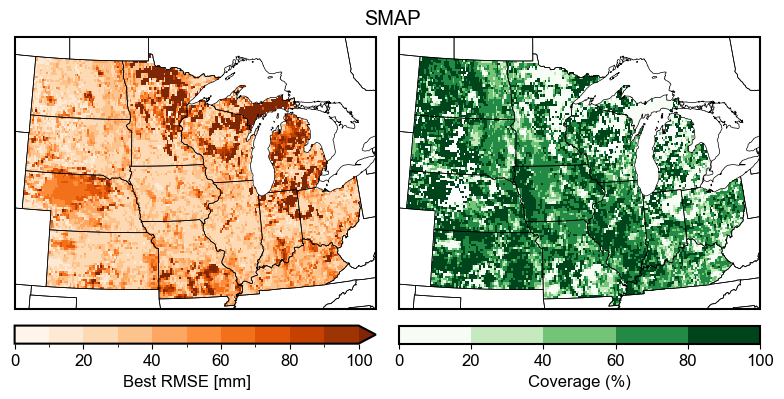

In [7]:
# SMAP
obs = 'smap'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

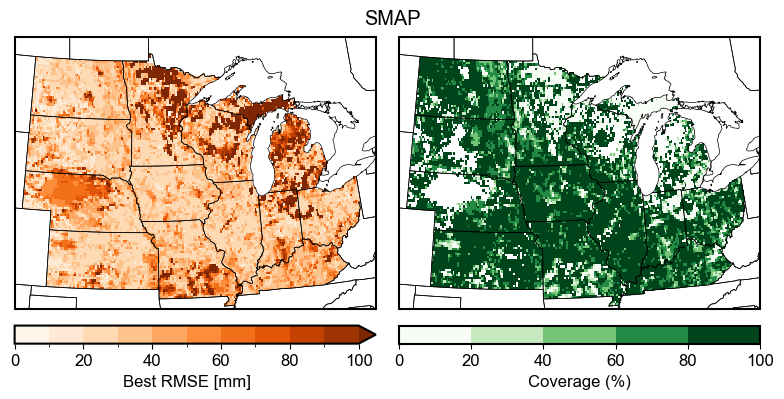

In [6]:
# SMAP
obs = 'smap'
n_cutoff = 500
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

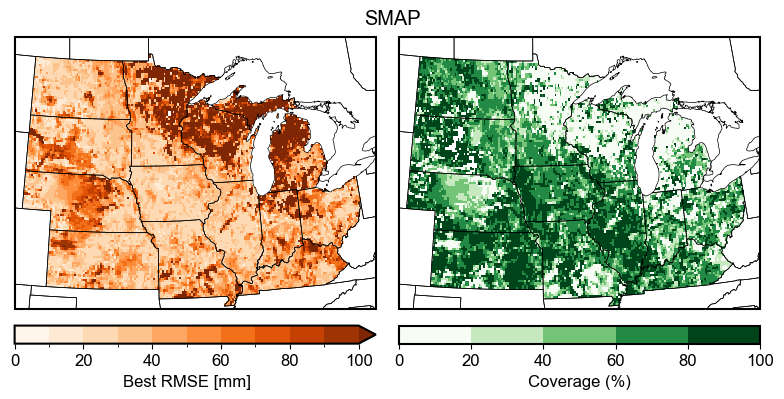

In [25]:
# SMAP
obs = 'smap'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

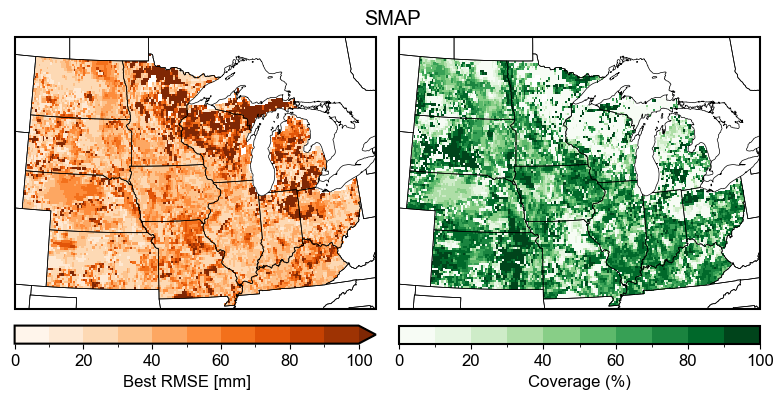

In [16]:
# SMAP old
obs = 'smap'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

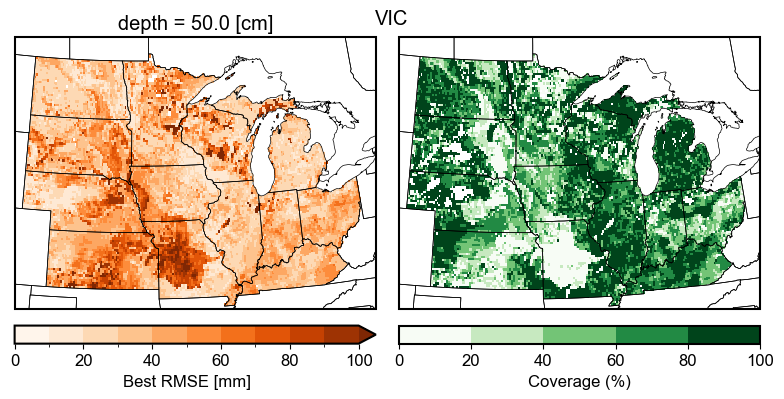

In [28]:
# VIC
obs = 'vic'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

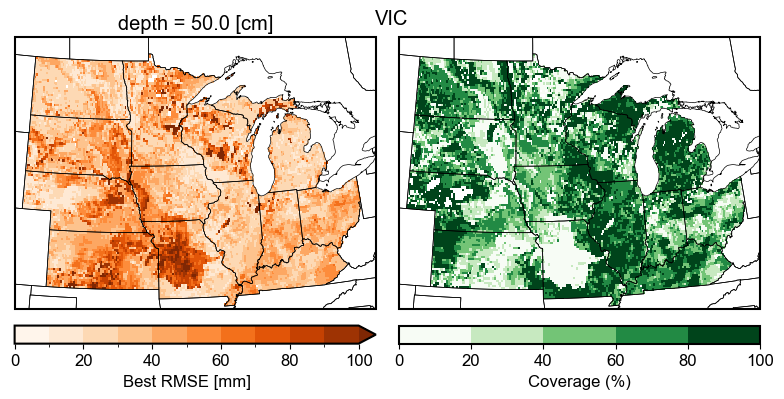

In [57]:
# VIC
obs = 'vic'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

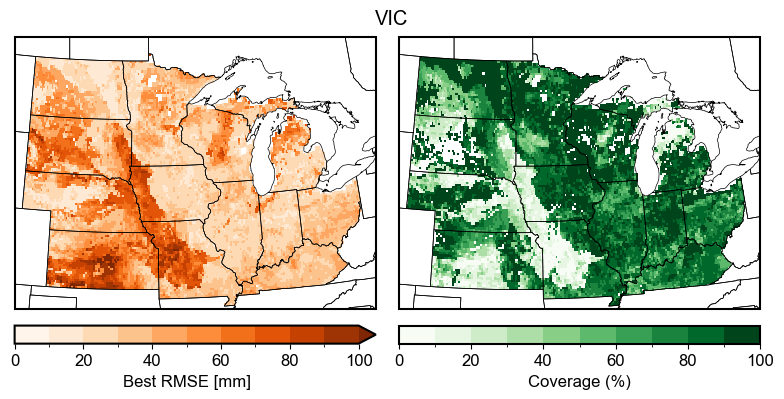

In [17]:
# VIC old
obs = 'vic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

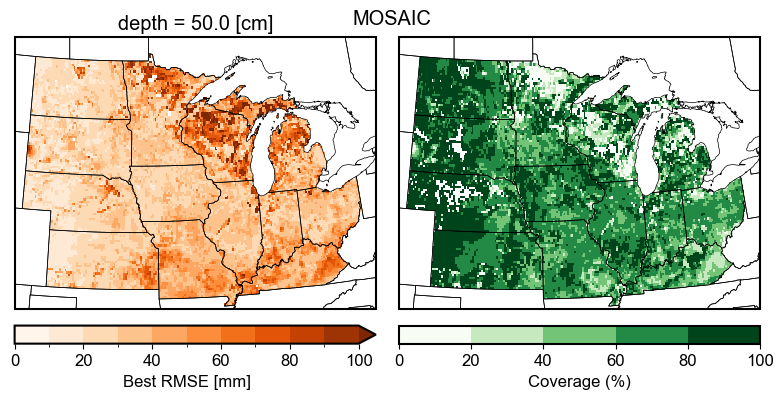

In [30]:
# MOSAIC
obs = 'mosaic'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

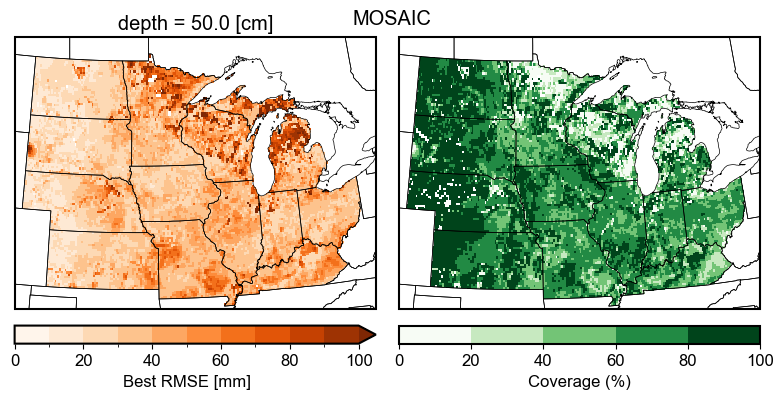

In [58]:
# MOSAIC
obs = 'mosaic'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

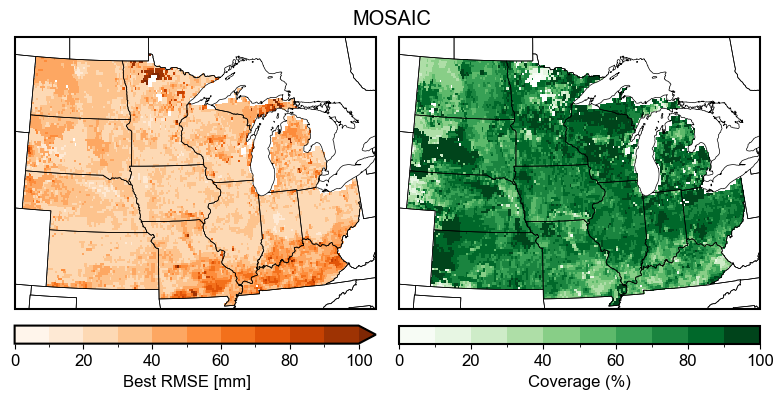

In [18]:
# MOSAIC old
obs = 'mosaic'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

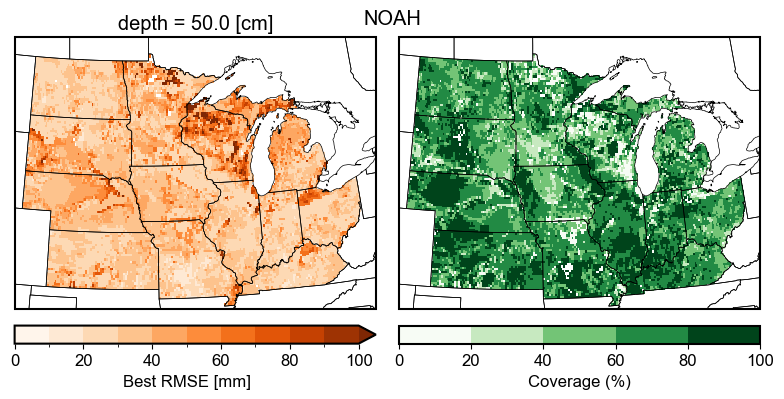

In [59]:
# NOAH
obs = 'noah'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

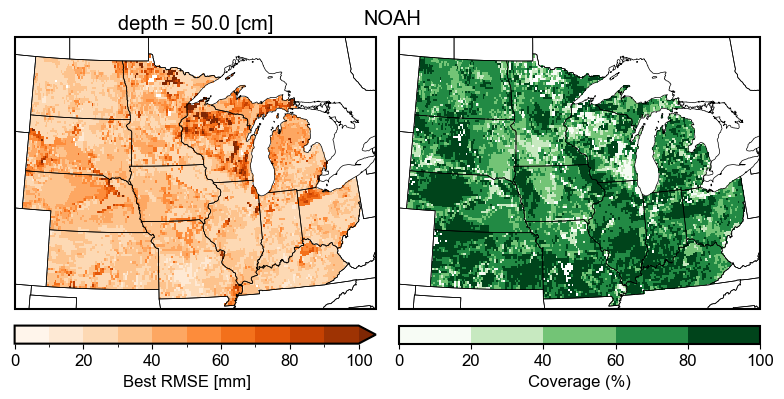

In [32]:
# NOAH
obs = 'noah'
n_cutoff = 100
tmin = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs=obs, n_cutoff=n_cutoff, tmin=tmin, axs=axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

# plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)
plt.show()

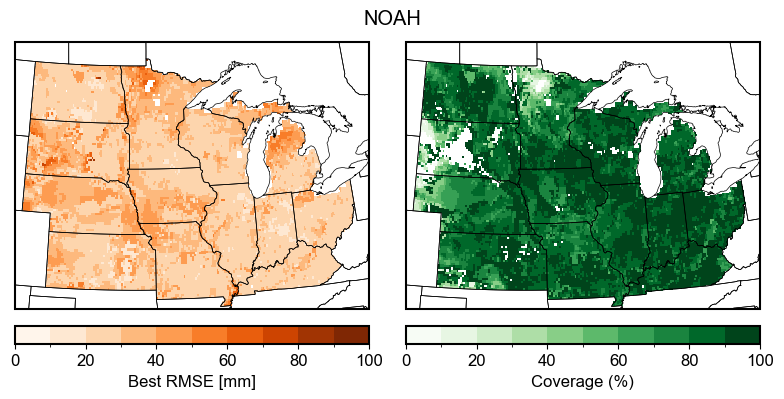

In [19]:
# NOAH old
obs = 'noah'
n_cutoff = 100

fig, axs = plt.subplots(1,2, figsize=(8,5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_map(obs, n_cutoff, axs)
fig.suptitle(obs.upper(), y=0.8)
fig.tight_layout()

plt.savefig(f'../figs/calibration_{obs.upper()}_spatial.png', dpi=300)

## OLD

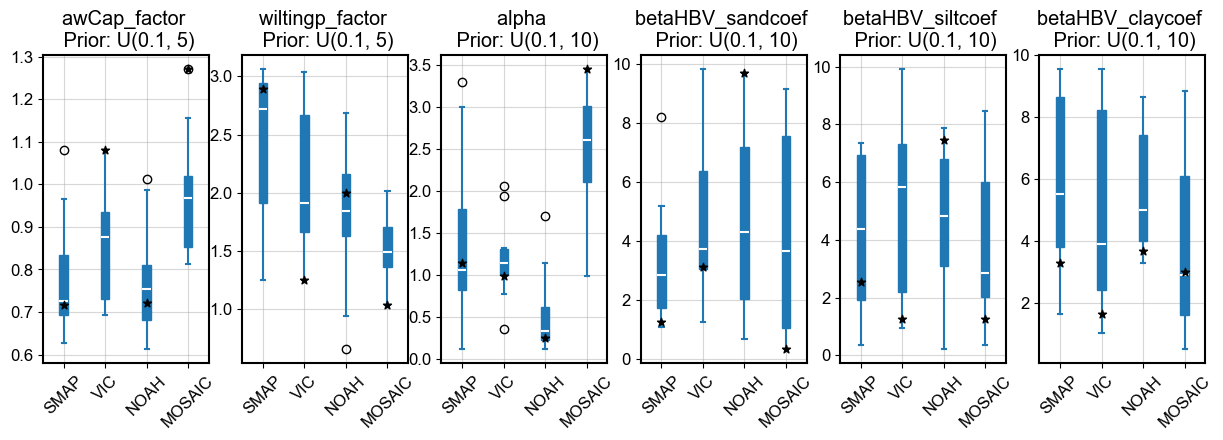

In [7]:
# Do the parameters match?
n_cutoff = 10

params = ['awCap_factor', 'wiltingp_factor', 'alpha', 'betaHBV_sandcoef', 'betaHBV_siltcoef', 'betaHBV_claycoef']
priors = ['U(0.1, 5)', 'U(0.1, 5)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)', 'U(0.1, 10)']
obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['C1', 'C2', 'C3', 'C4']
obs_colors = ['C0', 'C0', 'C0', 'C0']

fig, axs = plt.subplots(1,len(params), figsize=(15,4))

for ido, obs in enumerate(obs_all):
    # Get top params
    iparam_top_n = df_res.sort_values(by=f'{obs}_rmse')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        # Plot
        data = df_params.iloc[iparam_top_n][param]
        bplot = axs[idx].boxplot(x=data,
                                 vert=True,
                                 positions=[ido],
                                 widths=0.2,
                                 boxprops=dict(color=obs_colors[ido]),
                                 whiskerprops=dict(color=obs_colors[ido], lw=1.5),
                                 medianprops=dict(color='white', lw=1.5),
                                 capprops=dict(color=obs_colors[ido], lw=1.5),
                                 patch_artist=True)
        for patch in bplot['boxes']:
            patch.set_facecolor(obs_colors[ido])
        # Best
        axs[idx].scatter(x = [ido],
                         y = data[iparam_best],
                         marker = '*', color='black', zorder=100)


for idx, ax in enumerate(axs):
    ax.set_title(f'{params[idx]} \n Prior: {priors[idx]}')
    ax.set_xticks(ticks=[0,1,2,3],
                  labels=[obs.upper() for obs in obs_all], rotation=45)
    ax.grid(alpha=0.5)

plt.show()

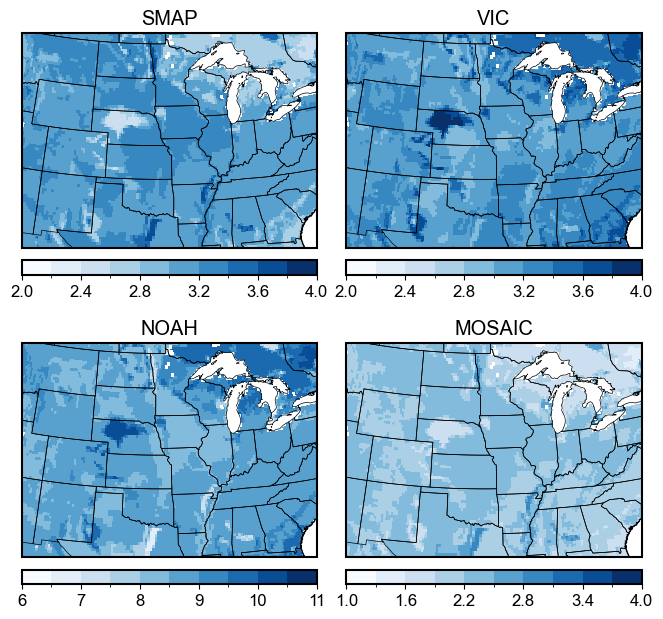

In [82]:
# Plot betaHBV
ds_soilfrac = xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/soilfrac_NLDASgrid.nc')

fig, axs = plt.subplots(2,2, figsize=(8,8),
                        subplot_kw=dict(projection=ccrs.LambertConformal()),
                        gridspec_kw=dict(wspace=0.1, hspace=0.01))
axs = axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get best param set
    iparam_best = df_res.sort_values(by=f'{obs}_rmse')['iparam'].iloc[0]
    # Calculate best betaHBV map
    betaHBV_sandcoef = df_params.iloc[iparam_best]['betaHBV_sandcoef']
    betaHBV_siltcoef = df_params.iloc[iparam_best]['betaHBV_siltcoef']
    betaHBV_claycoef = df_params.iloc[iparam_best]['betaHBV_claycoef']

    betaHBV = 1. + (betaHBV_sandcoef * ds_soilfrac['GLDAS_soilfraction_sand']) + \
    (betaHBV_siltcoef * ds_soilfrac['GLDAS_soilfraction_silt']) + \
    (betaHBV_claycoef * ds_soilfrac['GLDAS_soilfraction_clay'])
    # Plot
    p = betaHBV.plot(ax=axs[ido], vmin=np.round(betaHBV.min()-0.5), vmax=np.round(betaHBV.max()+0.5), cmap="Blues", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
    # Tidy
    axs[ido].set_title(obs.upper())
    # cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label=None,
                 ax=axs[ido],
                 pad=0.04)

# Tidy
xlims = [-110, -80] # central US
ylims = [30,49] # central US
for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
plt.show()

## Soil moisture 'obs' plots

In [16]:
# Error calculation function
def calculate_error_metrics(ds1, ds2, weekly_anom):
    # Weekly anomalies if needed
    def get_weekly_anomaly(ds):
        ds_tmp = ds.copy()
        ds_tmp = ds_tmp.assign_coords(week=ds_tmp.time.dt.strftime("%W"))
        return (ds_tmp.groupby('week') - ds_tmp.groupby("week").mean("time"))
    
    # Calculate weekly anom if desired
    if weekly_anom:
        ds1_tmp = get_weekly_anomaly(ds1)
        ds2_tmp = get_weekly_anomaly(ds2)
    else:
        ds1_tmp = ds1.copy()
        ds2_tmp = ds2.copy()
    
    # Linear correlation
    out_corr = xr.corr(ds1_tmp, ds2_tmp, dim='time')
    
    # MSE
    out_mse = np.sqrt(((ds1_tmp - ds2_tmp)**2)).mean(dim='time')

    # Merge and return
    out = xr.merge([xr.Dataset({'perason_r':out_corr}),
                    xr.Dataset({'rmse':out_mse})])

    return out

In [7]:
# Read all
ds_vic = xr.open_mfdataset(f'{nldas_path}/VIC/daily/*A20*.nc')['SOILM0_100cm'].isel(depth=0)
ds_noah = xr.open_mfdataset(f'{nldas_path}/NOAH/daily/*A20*.nc')['SOILM'].isel(depth=1)
ds_mosaic = xr.open_mfdataset(f'{nldas_path}/MOSAIC/daily/*A20*.nc')['SOILM'].isel(depth=1)

ds_smap = xr.open_mfdataset(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')['sm_rootzone']

In [8]:
%%time 

# Calculate all error metrics
weekly_anom = True

vic_noah_error = calculate_error_metrics(ds_vic, ds_noah, weekly_anom).compute()
vic_mosaic_error = calculate_error_metrics(ds_vic, ds_mosaic, weekly_anom).compute()
vic_smap_error = calculate_error_metrics(ds_vic, ds_smap, weekly_anom).compute()

noah_mosaic_error = calculate_error_metrics(ds_noah, ds_mosaic, weekly_anom).compute()
noah_smap_error = calculate_error_metrics(ds_noah, ds_smap, weekly_anom).compute()

mosaic_smap_error = calculate_error_metrics(ds_mosaic, ds_smap, weekly_anom).compute()

CPU times: user 6min, sys: 8.16 s, total: 6min 8s
Wall time: 6min 19s


In [ ]:
# Store all
vic_noah_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_noah_errors.nc')
vic_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_mosaic_errors.nc')
vic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/vic_smap_errors.nc')

noah_mosaic_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_mosaic_errors.nc')
noah_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/noah_smap_errors.nc')

mosaic_smap_error.to_netcdf(f'{project_data_path}/WBM/soil_obs_errors/mosaic_smap_errors.nc')

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(12,8),
#                         subplot_kw={'projection':ccrs.LambertConformal()},
#                        gridspec_kw={'wspace':0.05})

# p_corr = vic_noah_error.corr.plot(ax=axs[0], transform=ccrs.PlateCarree(),
#                                   add_colorbar=False,
#                                   levels=11
#                                  )
# p_mse = vic_noah_error.mse.plot(ax=axs[1], transform=ccrs.PlateCarree(),
#                                 add_colorbar=False,
#                                 levels=11
#                                )

# axs[0].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)
# axs[1].add_feature(cfeature.STATES, edgecolor='white', linewidth=1)

# fig.colorbar(p_corr, ax = axs[0],
#              orientation="horizontal",
#              label="Linear correlation",
#              pad=0.04)

# fig.colorbar(p_mse, ax = axs[1],
#              orientation="horizontal",
#              label="Mean Square Error",
#              pad=0.04)

# fig.suptitle("Noah VIC soil moisture anomaly comparison (2016-2022)", y=0.63)

# plt.show()

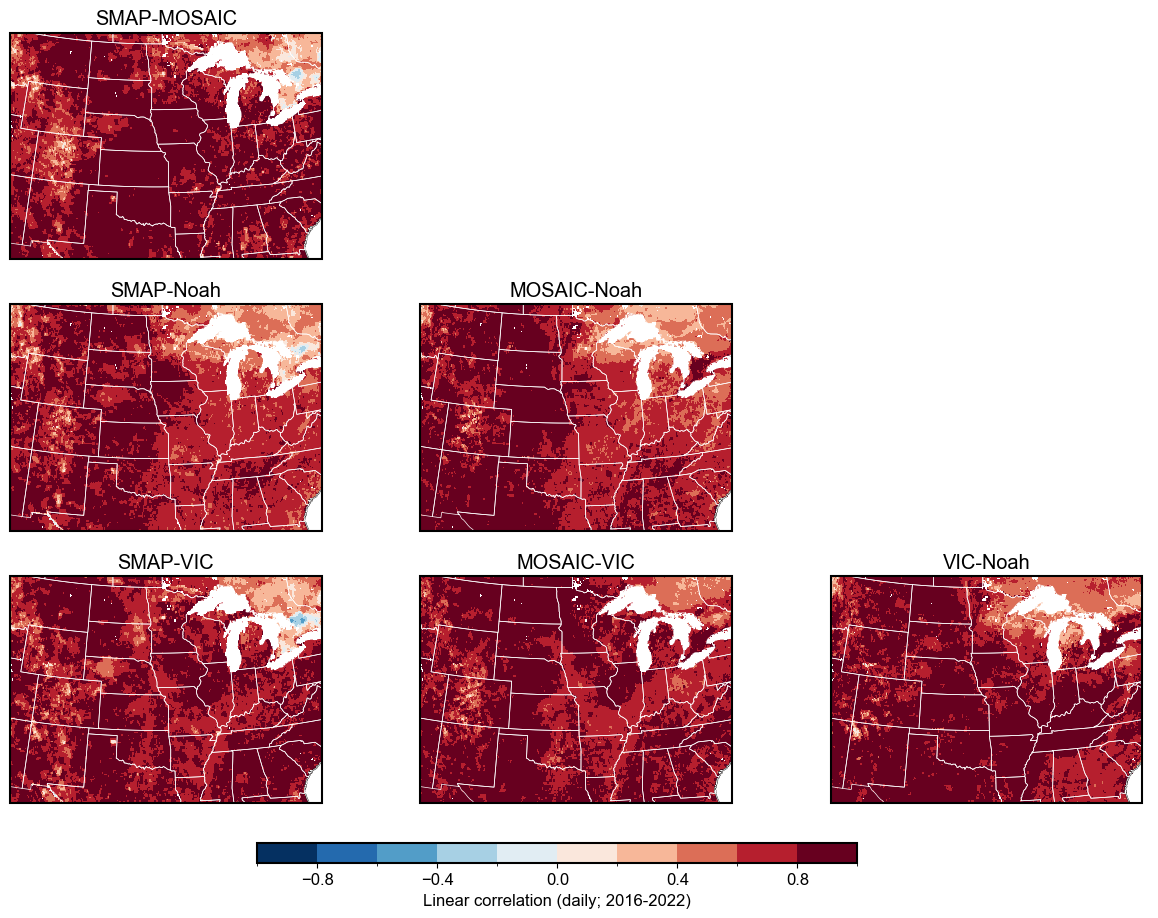

In [12]:
# Correlation plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.corr.plot(ax=axs[0,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.corr.plot(ax=axs[1,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.corr.plot(ax=axs[2,0], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.corr.plot(ax=axs[1,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.corr.plot(ax=axs[2,1], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.corr.plot(ax=axs[2,2], vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Linear correlation (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()

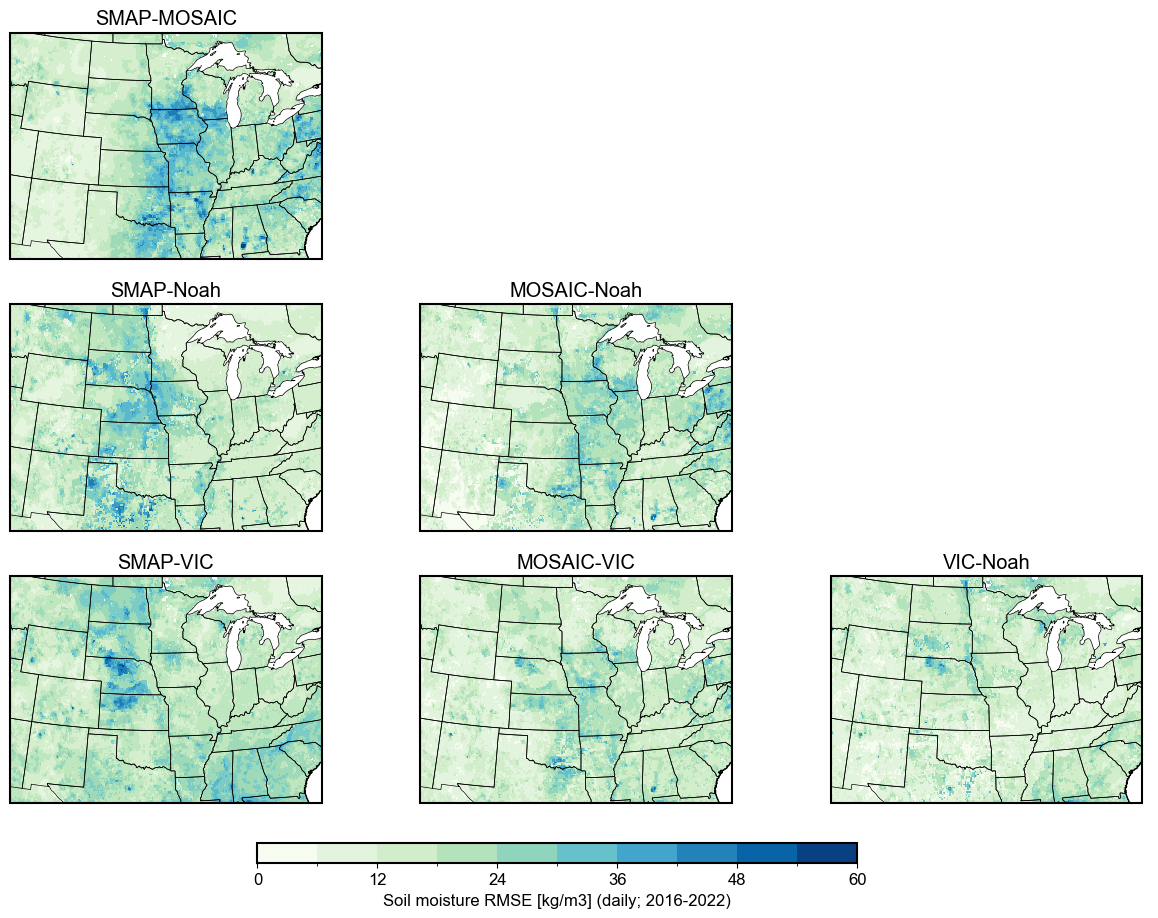

In [15]:
# RMSE plot
fig, axs = plt.subplots(3,3, figsize=(15,10), subplot_kw=dict(projection=ccrs.LambertConformal()))

xlims = [-110, -80] # central US
ylims = [30,49] # central US

mosaic_smap_error.mse.plot(ax=axs[0,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[0,0].set_title("SMAP-MOSAIC")

noah_smap_error.mse.plot(ax=axs[1,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,0].set_title("SMAP-Noah")

vic_smap_error.mse.plot(ax=axs[2,0], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,0].set_title("SMAP-VIC")

noah_mosaic_error.mse.plot(ax=axs[1,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[1,1].set_title("MOSAIC-Noah")

vic_mosaic_error.mse.plot(ax=axs[2,1], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,1].set_title("MOSAIC-VIC")

p=vic_noah_error.mse.plot(ax=axs[2,2], vmin=0, vmax=60, cmap="GnBu", add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
axs[2,2].set_title("VIC-Noah")

for ax in [axs[0,0],axs[1,0],axs[2,0],axs[1,1],axs[2,1],axs[2,2]]:
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], ccrs.Geodetic())
    
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p,
                    cax=cbar_ax,
                    orientation="horizontal",
                    label="Soil moisture RMSE [kg/m3] (daily; 2016-2022)")

# plt.savefig('./figs/pearson_GMFD-PRISM-gridMET_1981-2014_Hamon_midwest.png', dpi=600)
plt.show()